# Predicting Pet Insurance Claims - Exploratory Data Analysis

## 1 Introduction

### 1.1 Background
Whenever a pet insurance policy holder incurs veterinary expenses related to their enrolled pet, they can submit claims for reimbursement, and the insurance company reimburses eligible expenses. To price insurance products correctly, the insurance company needs to have a good idea of the amount their policy holders are likely to claim in the future. 

### 1.2 Project Goal
The goal of this project is to create a machine learning model to predict how much (in dollars) a given policy holder will claim for during the second year of their policy. 

### 1.3 Initial Questions for EDA
Below are a few initial questions to answer and areas of interest for the detailed data analysis.
* What patterns or relationships exist between species and our other features?
* What is the distribution of our claims amounts by year? By breed? By species? By Age?
* Does enroll path matter when it comes to claims amounts?

Let's get started by importing the data we cleaned up in the data wrangling notebook.

## 2 Setup

### 2.1 Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

### 2.2 Data Load & Preview

In [2]:
# Read in the data file generated during data wrangling
df = pd.read_csv('../data/merged_pets.csv')

# Preview
df.head()

,PetId,Species,Breed,Premium,Deductible,EnrollPath,AgeYr1,YoungAge,MixedBreed,AmtClaimsYr1,AmtClaimsYr2,AvgClaimsYr1,AvgClaimsYr2,NumClaimsYr1,NumClaimsYr2,AmtClaimsTotal,AvgClaimsTotal,NumClaimsTotal
0,0,Dog,Schnauzer Standard,84.54,200,Web,3,0,0,0.00,1242.00,0.000000,621.000,0,2,1242.00,621.000000,2
1,1,Dog,Yorkiepoo,50.33,500,Phone,0,0,0,0.00,0.00,0.000000,0.000,0,0,0.00,0.000000,0
2,2,Dog,Mixed Breed Medium,74.00,500,Phone,0,0,1,640.63,1187.68,213.543333,237.536,3,5,1828.31,451.079333,8
3,3,Dog,Labrador Retriever,57.54,500,Phone,0,0,0,0.00,0.00,0.000000,0.000,0,0,0.00,0.000000,0
4,4,Dog,French Bulldog,60.69,700,Web,0,0,0,7212.25,168.75,801.361111,168.750,9,1,7381.00,970.111111,10


In [3]:
df.shape

(50000, 18)

### 2.3 Data Wrangling Summary 
Before we get started on the analysis, let's take a moment to recap what we've learned so far and what the data looks like.

#### 2.3.1 What do we know? 
* **Shape** - Our clean dataframe is 50000 rows with each row corresponding to a single pet.
* **Basic Info** - For each pet, we have some basic info including species, breed, age at time of enrollment and enroll path.
* **Policy Info** - We also have policy-level info for each pet including the monthly premium and deductible amount for claims.
* **Claims Data** - We also have claims data for each pet covering the first two policy years including:
    * Number of claims per year and total (years 1 and 2 combined)
    * Average claim amount per year and total (years 1 and 2 combined) 
    * Amount of claims per year and total (years 1 and 2 combined)
* **New Columns** - Finally, we have a couple of columns we generated during data wrangling to capture specific aspects of the data. These include:
    * YoungAge - Designation for pets who enrolled at a very young age (< 7 weeks)
    * MixedBreed - Designation for pets classified as some sort of *mixed* breed

#### 2.3.2 Initial Observations
* **Species** - We have two species of pets, Cats and Dogs
* **Breed** - We have 373 unique breeds in total (55 cat and 318 dog)
* **Age** - The age range is between 0 (i.e., < 1 year) and 13
* **Premium** - Premiums fall into a wide range with a few outlier values close to \\$1000
* **Deductible** - Deductibles are fairly well distributed and appear to be stratified across a range of common values.
* **Claims** 
    * For cats and dogs, the median value for total number and total amount of claims is 0.
    * On the flip side, both species have some significant outliers in both categories (number and amount of claims)
    
Now that we have a bit more context, let's jump in to the analysis.

## 3 Data Analysis
As a first step, we'll look at our count of pets per species. With that as our jumping off point, we can start investigating the first question from the intro... What patterns or relationships exist between species and our other features?

### 3.1 What is the count of pets per species?

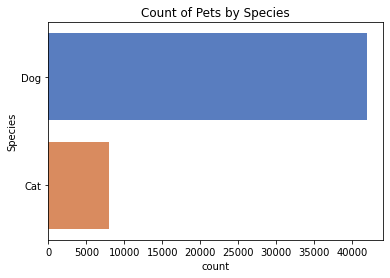

In [4]:
# Plot a count of each species
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.countplot(y='Species', data=df, palette='muted').set(title="Count of Pets by Species")
plt.show()

As observed in data wrangling, we have approximately 50,000 pets in our data, roughly 85% of which are dogs. The remaining 15% are cats, so that keeps things fairly simple as we only have two breeds to compare. 

**But why do we see such a big discrepency in the number of dogs vs. the number of cats?**

It could mean that dogs are a more popular option for a pet, or it could mean that dogs are more expensive to keep healthy and insurance is needed. If that's the case, we should see dogs having higher premiums and/or higher deductibles. 

Next, we'll plot the distribution of premium and deductible by species to see how they look side-by-side. We know we have some outlier values in premium that will lead to a skewed distribution. Let's zoom in on the lower end to get a better look.

### 3.2 Do dogs cost more to insure?

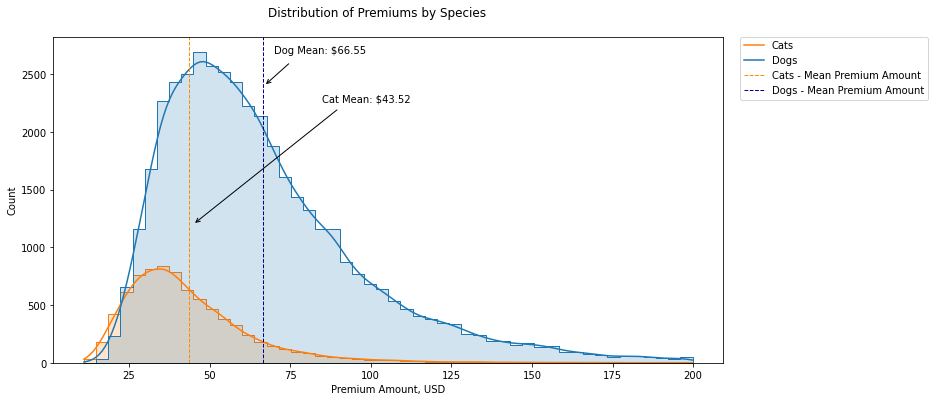

In [11]:
# Filter out the outlier premiums
x = df[df.Premium < 200][['Premium', 'Species']]
dog_mean = x[x.Species == 'Dog']['Premium'].mean()
cat_mean = x[x.Species == 'Cat']['Premium'].mean()

# Create a histogram showing premium amounts by species
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(x=x.Premium, data=df, hue='Species', alpha=0.2,
             element='step', bins=50, kde=True).set(title="", xlabel="Premium Amount, USD")

# Plot mean premium amount for dogs and cats
plt.axvline(cat_mean, color='darkorange', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(cat_mean*1.95, max_ylim*0.8, 'Cat Mean: ${:.2f}'.format(cat_mean))
ax.annotate("", xy=(45, 1200), xytext=(90, 2200), arrowprops=dict(arrowstyle="->"))

plt.axvline(dog_mean, color='darkblue', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(dog_mean*1.05, max_ylim*0.95, 'Dog Mean: ${:.2f}'.format(dog_mean))
ax.annotate("", xy=(67, 2400), xytext=(75, 2600), arrowprops=dict(arrowstyle="->"))

# Add title and display clot
plt.suptitle("Distribution of Premiums by Species", y=0.95)
plt.legend(labels=(['Cats', 'Dogs', "Cats - Mean Premium Amount", "Dogs - Mean Premium Amount" ]),
           bbox_to_anchor=(1.025, 1), loc='upper left', borderaxespad=0)
plt.show()

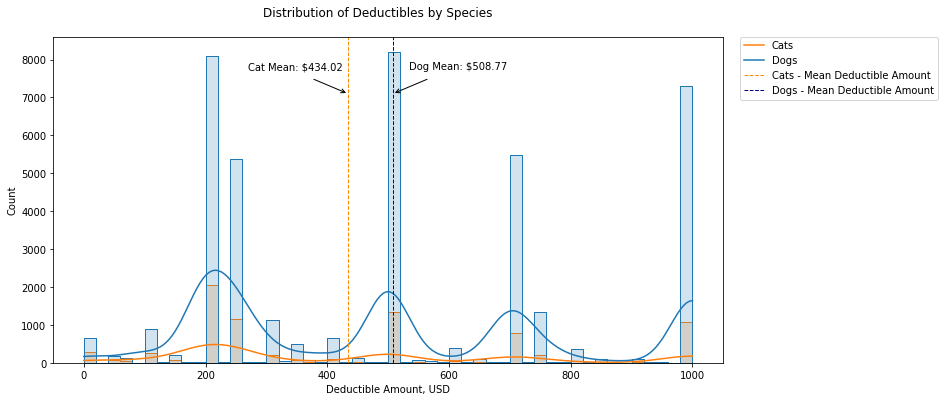

In [9]:
# Filter out the outlier premiums
x = df[df.Premium < 200][['Deductible', 'Species']]
dog_mean = x[x.Species == 'Dog']['Deductible'].mean()
cat_mean = x[x.Species == 'Cat']['Deductible'].mean()

# Create a histogram showing deductible amounts by species
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(x='Deductible', data=df, hue='Species', alpha=0.2,
             element='step', bins=50, kde=True).set(title="", xlabel="Deductible Amount, USD")

# Plot mean deductible amount for dogs and cats
plt.axvline(cat_mean, color='darkorange', linestyle='dashed', linewidth=1, label="Cats - Mean Deductible Amount")
# min_ylim, max_ylim = plt.ylim()
# plt.text(cat_mean*0.62, max_ylim*0.9, 'Cat Mean: ${:.2f}'.format(cat_mean))
# ax.annotate("", xy=(434, 7100), xytext=(375, 7500), arrowprops=dict(arrowstyle="->"))

plt.axvline(dog_mean, color='darkblue', linestyle='dashed', linewidth=1)
# min_ylim, max_ylim = plt.ylim()
# plt.text(dog_mean*1.05, max_ylim*0.9, 'Dog Mean: ${:.2f}'.format(dog_mean))
# ax.annotate("", xy=(508, 7100), xytext=(567, 7500), arrowprops=dict(arrowstyle="->"))

# Add title and display clot
plt.suptitle("Distribution of Deductibles by Species", y=0.95)
plt.legend(labels=(['Cats', 'Dogs', "Cats - Mean Deductible Amount", "Dogs - Mean Deductible Amount" ]), 
           bbox_to_anchor=(1.025, 1), loc='upper left', borderaxespad=0)
plt.show()

Looking at the premium distribution curves, the trends appear to be similar for both species but with dogs shifted further to the right. By adding the mean premium values, it's clear that dog owners do pay higher premiums *on average* when compared to cats.

As for deductible, we see a similar striation of the data for both dogs and cats with no discernable differences in the distribution other than the difference in the total count of each species. Adding the mean line for each species though shows us that dogs do have higher deductibles by ~\\$75 on average.   

Let's try incorporating the dimension of age to see how age factors in to both of these features. We would definitely expect to see premium amount rise with age, but what about deductible?

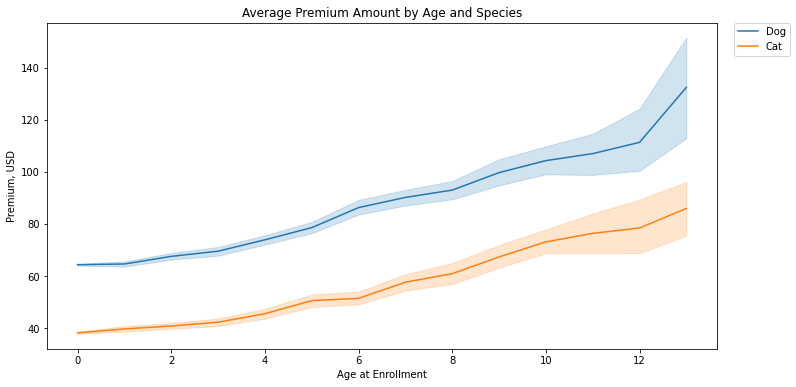

In [7]:
# Create a line plot showing premium by species and age
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.lineplot(x='AgeYr1', y='Premium', data=df,
             hue='Species', ci=95).set(title="Average Premium Amount by Age and Species", 
                               ylabel="Premium, USD", xlabel="Age at Enrollment")
plt.legend(bbox_to_anchor=(1.025, 1), loc='upper left', borderaxespad=0)
plt.show()

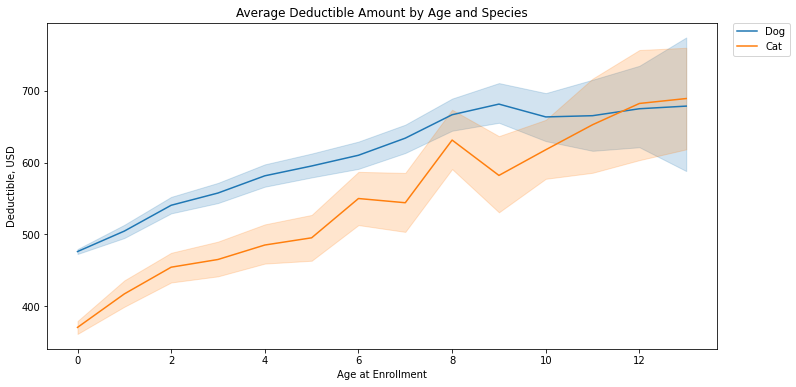

In [8]:
# Create a line plot showing deductible by species and age
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.lineplot(x='AgeYr1', y='Deductible', data=df,
             hue='Species', ci=95).set(title="Average Deductible Amount by Age and Species",
                                xlabel="Age at Enrollment",ylabel="Deductible, USD")
plt.legend(bbox_to_anchor=(1.025, 1), loc='upper left', borderaxespad=0)
plt.show()

The line plots above indicate a clear upward trend in both premium and deductible amounts as pets age. We do see that our confidence interval gets larger as pets get older which could be a sign that these two features become less useful in their predictive power for older pets.

Another interesting observation related to deductible amount is that while dogs have higher deductibles on average at nearly every age, there is a crossover point at age 12-13 where that relationship flips. Possible older cats have more health problems than older dogs, or maybe the higher deductibles are making up for what we observed in terms of lower premium amounts. 

**Summary**
* Dogs and cats both have a broad range of premiums and deductibles with similar distributions for each 
* On average, dogs have higher premiums and higher deductibles than cats (*except above age 12*)
* Both premium and deductible tend to increase with age with greater variability as age increases

So we are starting to see a picture here that *generally*, dogs are more expensive than cats. Let's see if that relationship extends to our claims data as well.

### 3.3 Do dogs have higher claims or more claims than cats?
Above, we observed that *on average*, dog owners pay higher insurance premiums and have higher deductible than cat owners. Intuitively, that should mean that dog owners have higher total claims amounts than cat owners. 

Based on what we observed in data wrangling, we know there are some very significant outliers in terms of claims amounts that will affect the interpretability of our plots. Let's filter down to a smaller range and take a look at the data.

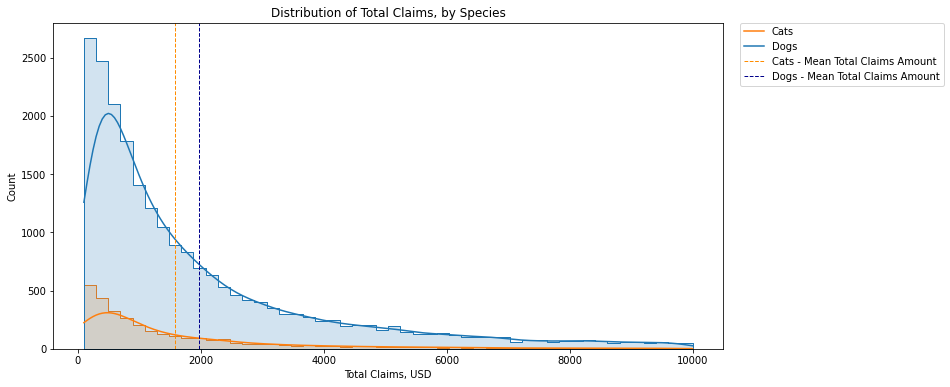

In [12]:
# Filter out outliers for number of claims and claim amounts
filtered_df = df[(df.AmtClaimsTotal < 10000) & (df.AmtClaimsTotal > 100) &
                 (df.NumClaimsTotal < 30) & (df.NumClaimsTotal > 0)]

# Create a histogram showing total claims by species
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(x="AmtClaimsTotal", data=filtered_df, hue='Species', alpha=0.2,
             element='step', bins=50, kde=True).set(title="Distribution of Total Claims, by Species",
                                          xlabel="Total Claims, USD")

# Plot mean total claims amount for dogs and cats
plt.axvline(filtered_df[filtered_df.Species == 'Cat'].AmtClaimsTotal.mean(), color='darkorange',
            linestyle='dashed', linewidth=1)
# min_ylim, max_ylim = plt.ylim()
# plt.text(cat_mean*0.62, max_ylim*0.9, 'Cat Mean: ${:.2f}'.format(cat_mean))
# ax.annotate("", xy=(434, 7100), xytext=(375, 7500), arrowprops=dict(arrowstyle="->"))

plt.axvline(filtered_df[filtered_df.Species == 'Dog'].AmtClaimsTotal.mean(), color='darkblue',
            linestyle='dashed', linewidth=1)
# min_ylim, max_ylim = plt.ylim()
# plt.text(dog_mean*1.05, max_ylim*0.9, 'Dog Mean: ${:.2f}'.format(dog_mean))
# ax.annotate("", xy=(508, 7100), xytext=(567, 7500), arrowprops=dict(arrowstyle="->"))

# Plot legend and display
plt.legend(labels=(['Cats', 'Dogs', 'Cats - Avg. Total Claims Amount', 'Dogs - Avg. Total Claims Amount']),
           bbox_to_anchor=(1.025, 1), loc='upper left', borderaxespad=0)
plt.show()

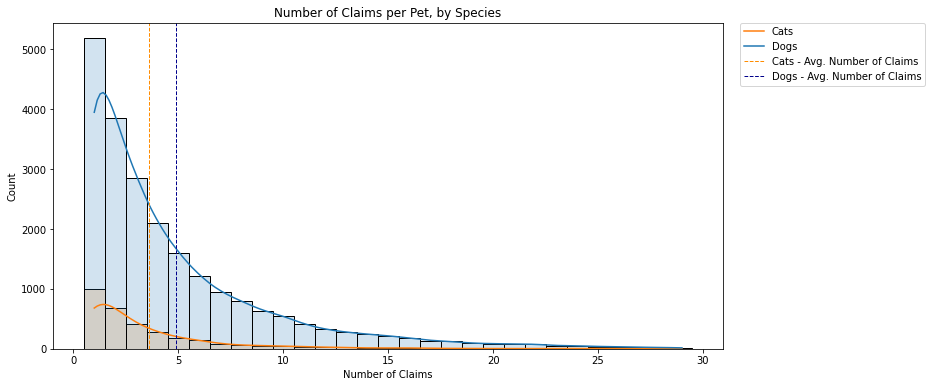

In [14]:
# Create a histogram showing number of claims per pet by species
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(x="NumClaimsTotal", data=filtered_df, hue='Species', alpha=0.2,
             element='bars', bins=30, kde=True,
             discrete=True).set(title="Number of Claims per Pet, by Species", xlabel="Number of Claims")

# Plot mean total claims amount for dogs and cats
plt.axvline(filtered_df[filtered_df.Species == 'Cat'].NumClaimsTotal.mean(), color='darkorange',
            linestyle='dashed', linewidth=1)
# min_ylim, max_ylim = plt.ylim()
# plt.text(cat_mean*0.62, max_ylim*0.9, 'Cat Mean: ${:.2f}'.format(cat_mean))
# ax.annotate("", xy=(434, 7100), xytext=(375, 7500), arrowprops=dict(arrowstyle="->"))

plt.axvline(filtered_df[filtered_df.Species == 'Dog'].NumClaimsTotal.mean(), color='darkblue',
            linestyle='dashed', linewidth=1)
# min_ylim, max_ylim = plt.ylim()
# plt.text(dog_mean*1.05, max_ylim*0.9, 'Dog Mean: ${:.2f}'.format(dog_mean))
# ax.annotate("", xy=(508, 7100), xytext=(567, 7500), arrowprops=dict(arrowstyle="->"))

# Plot legend and display
plt.legend(labels=(['Cats', 'Dogs', 'Cats - Avg. Number of Claims', 'Dogs - Avg. Number of Claims']),
           bbox_to_anchor=(1.025, 1), loc='upper left', borderaxespad=0)
plt.show()

So based on this, it seems clear that on average, dogs have more claims (\~1.3 more claims per pet) and higher total claims amounts (~\\$500). Let's summarize the key takeaways for claims and then move on to enroll path.  

**Summary**
* The distributions for total number of claims and total amount of claims follow similar trends for dogs and cats 
* On average, dogs have more claims (~1.3 more claims per pet) than cats
* On average, dogs have higher total claims amounts (~\\$500) than cats

**Conclusion**
Species does appear to be a factor in claims amounts and we should consider accounting for this in the  predictive model possibly by separating our pets based on species.

Next, let's take a look at enroll path to determine if this matters at all for our analysis.

### 3.4 Does enroll path tell us anything about pet claims?
Intuitively, it's probably safe to say no. But it could be the case that enroll path tells us something about the pet owners that translates into more or fewer claims. Let's start by looking at a count of pets in each category.

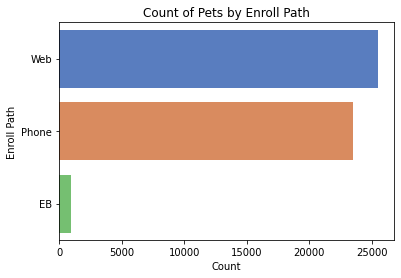

In [15]:
# Plot a count of pets in each enroll path
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.countplot(y='EnrollPath', data=df, palette='muted').set(title="Count of Pets by Enroll Path", 
                                                           ylabel="Enroll Path", xlabel="Count")
plt.show()

It looks like we have 3 possibilities, Web, Phone and EB. It's unclear what "EB" stands for, but luckliy that is a pretty small percentage of our data. The majority of pets were enrolled by either Web or Phone.

Since claims amounts are the focus of this project, let's see if there is any noticeable difference in the distributions of number or amount of claims related to enroll path. If not, it's probably safe for us to drop this column.

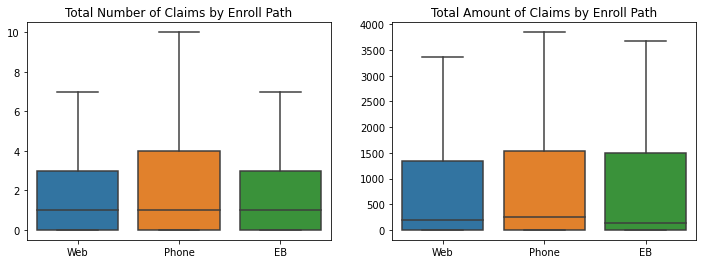

In [16]:
# Create box plots showing distribution of number and amount of claims by enroll path
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x="EnrollPath", y="NumClaimsTotal", data=df, ax=ax1,
            sym="").set(title = "Total Number of Claims by Enroll Path", xlabel="", ylabel="")
sns.boxplot(x="EnrollPath", y="AmtClaimsTotal", data=df, ax=ax2,
            sym="").set(title = "Total Amount of Claims by Enroll Path", xlabel="", ylabel="")
plt.show()

The distributions for the total amount of claims look very similar for web and phone. It's difficult to see much of a distribution for EB in this plot. Let's look at a scatterplot for each and add a regression line. 

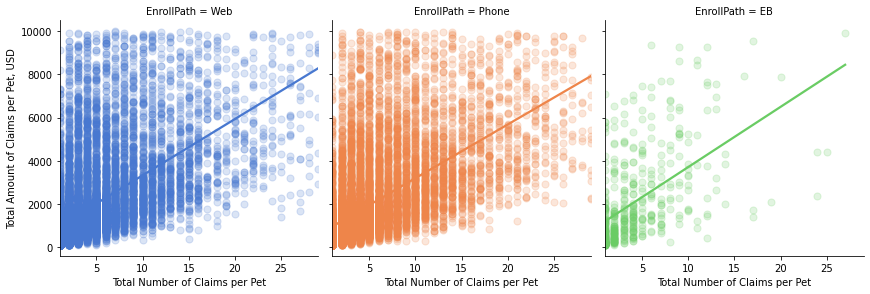

In [17]:
# Plot a regression model for each enroll path showing number of claims vs. amount of claims
g = sns.lmplot(x="NumClaimsTotal", y="AmtClaimsTotal", col="EnrollPath", hue="EnrollPath", data=filtered_df,
           ci=None, palette="muted", height=4, scatter_kws={"s": 50, "alpha": 0.2})
g.set_axis_labels("Total Number of Claims per Pet", "Total Amount of Claims per Pet, USD");

Adding the regression lines is a bit more helpful as we can see a similar trend across all three categories. For EB though, there's so little data that it's hard to trust the regression line as we get further out into the outliers.

While we do see some slight variation in the plots above, it doesn't seem to be significant enough to draw the conclusion that enroll path has an affect on number or amount of claims. Given this, we'll drop that column and move on.

In [18]:
# Drop EnrollPath
df = df.drop(columns=["EnrollPath"])

### 3.5 Does age factor into claims amounts?
This also seems obvious, but let's take a look at how the claims totals break down by Species and Age.

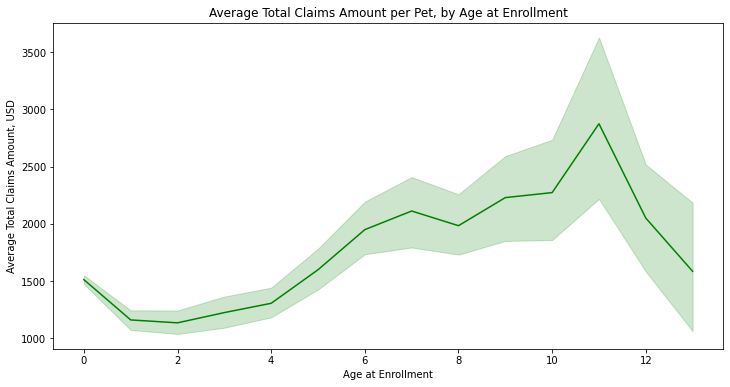

In [19]:
# Create a nested barplot showing total claims by Age
f, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.lineplot(x="AgeYr1", y="AmtClaimsTotal", data=df,
             color="Green").set(title="Average Total Claims Amount per Pet, by Age at Enrollment", 
                                 xlabel="Age at Enrollment", ylabel="Average Total Claims Amount, USD")
plt.show()

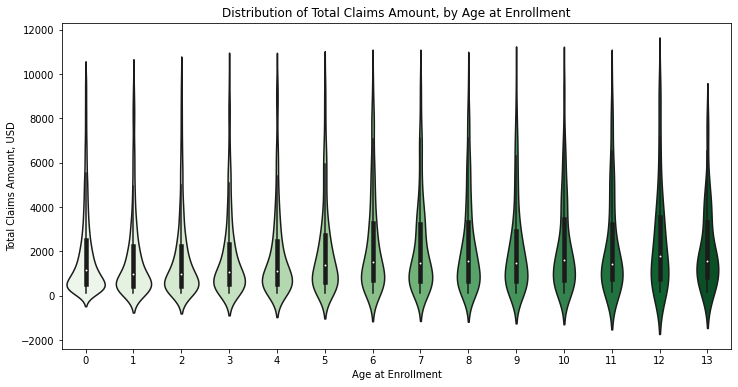

In [20]:
# Create a violin plot showing distribution of total claims based on year of enrollment
f, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.violinplot(x="AgeYr1", y="AmtClaimsTotal", data=filtered_df,
               palette="Greens").set(title="Distribution of Total Claims Amount, by Age at Enrollment", 
                                 xlabel="Age at Enrollment", ylabel="Total Claims Amount, USD")
plt.show()

The violin plot does a nice job of showing how the distribution of total claims amounts changes with age. As age increases, we see the spread of total claims amounts increasing as well. In this filtered view where we've capped total claims amounts at \\$10,000, it's hard to see what effect age has on the overall range of total claims. 

Before drawing conclusions, let's plot this again using the unfiltered data.

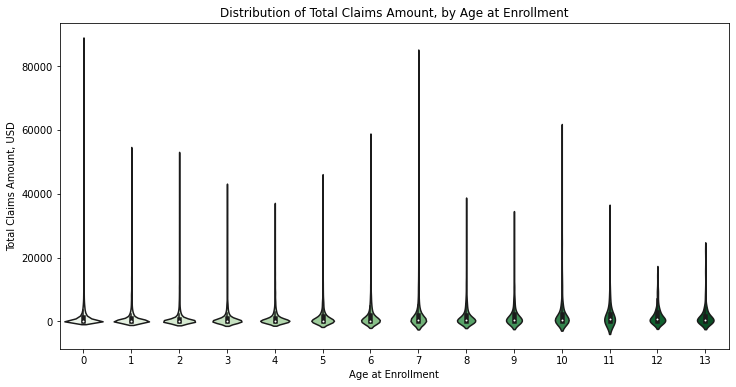

In [21]:
# Create a violin plot showing distribution of total claims based on year of enrollment
f, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.violinplot(x="AgeYr1", y="AmtClaimsTotal", data=df,
               palette="Greens").set(title="Distribution of Total Claims Amount, by Age at Enrollment", 
                                 xlabel="Age at Enrollment", ylabel="Total Claims Amount, USD")
plt.show()

Interesting! So while we might expect to see a much greater range of claims at the top end of the age spectrum, this does not match up with the data. In fact, we see the highest claims amounts in the youngest category of pets. We do still see evidence that the variability of total claims amounts increases with age, but it's less promounced when we factor in the outlier values.

**Summary**
* Total claims amounts tend to rise with age, to a point at least
* The variability of total claims amounts also rises with age
* Even very young pets can have significantly high values for total claims

**Conclusion:**
* Age matters when it comes to claims amounts, but it doesn't seem to follow a straighforward linear trajectory.

### 3.6 How many pets have claims in one or both years?
Earlier in data wrangling, we observed that a significant number of pets have no claims at all within the first two years. But what about the other pets... do the majority have claims in both years or only one year? Additionally, are there any patterns that jump out when we look at pets with claims in both years in terms of age, species, etc.?

In [22]:
# Create function to populate new column as count of number of years with claims (0, 1, 2)
def claim_yrs(row):
    if (row["NumClaimsTotal"] == 0):
        return 0
    elif ((row["NumClaimsYr1"] > 0) & (row["NumClaimsYr2"] > 0)):
        return 2
    else:
        return 1

# Apply function to df to create new column
df["YrsWithClaims"] = df.apply(claim_yrs, axis=1)

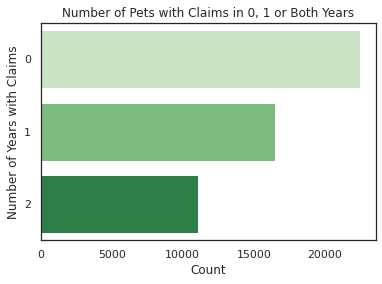

In [52]:
# Plot the count of pets with claims in 0, 1 or both years
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.countplot(y='YrsWithClaims', data=df,
              palette='Greens').set(title="Number of Pets with Claims in 0, 1 or Both Years",
                                    xlabel="Count", ylabel="Number of Years with Claims")
plt.show()

This confirms our earlier observation that 0 claims is the median value for cats and dogs. at all (58% for cats and 45% for dogs), but it's also interesting to see the number of pets with claims in one or both years.

Let's take a different view and see how this data looks when broken down by species. Since the dataset is unbalanced toward dogs by nearly 6 to 1, first we'll calculate the percentage of each species with claims in 0, 1 or 2 years. Then we'll plot the percentages by species and see what we get.

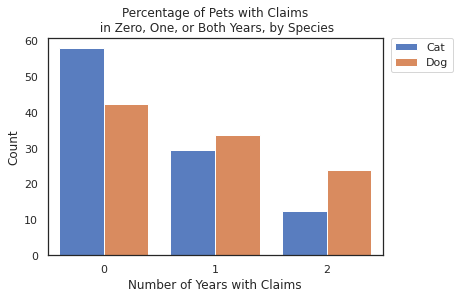

In [63]:
# Calculate the percentage of each species with claims in 0,1, or 2 years
claim_yr_counts = (df.groupby(['Species'])['YrsWithClaims']
                     .value_counts(normalize=True)
                     .rename('Percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('YrsWithClaims'))

# Plot the data 
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.barplot(x="YrsWithClaims", y="Percentage", hue="Species", data=claim_yr_counts, palette="muted", 
           ).set(title="Percentage of Pets with Claims\n in Zero, One, or Both Years, by Species",
                 xlabel="Number of Years with Claims", ylabel="Count")

# Plot the legend and display
plt.legend(bbox_to_anchor=(1.025, 1), loc='upper left', borderaxespad=0)
plt.show()

Based on earlier observations, we know that dogs outnumber cats by a large margin in our data. By plotting the percentages of each species with claims in zero, one, or both years, we see s somewhat unexpected result. Dogs are less likely to have claims overall and cats are more likely to have claims in both policy years.

**Summary**
* Around one half of pets in both species have no claims at all
* Based on percentages of each species, cats are more likely to have claims in one or both years.

# Start Here - DRAFT ONLY BELOW THIS LINE

## 3.7 Does breed factor into claims amounts in a significant way?

* Does it make sense to look at the proportion of a breed with high claims and see if any of the breeds stand out?
* Should I only pay attention to this is the breeds in question have a count of pets higher than some significant number (e.g., 30)?

### Cat breeds
Since we only have ~35 total cat breeds, we can take a quick look at a rollup of claims data for all breeds to help guide next steps.

In [ ]:
# # Group cats by breed and aggregate claims data columns
# cats_by_breed = cats.groupby('Breed').agg({'PetId': ['count'],
#                                            'NumClaimsYr1':['mean'],
#                                            'NumClaimsYr2':['mean'],
#                                            'AmtClaimsYr1':['mean', 'median', 'min', 'max'], 
#                                            'AmtClaimsYr2':['mean', 'median', 'min', 'max']}
#                                          )
# # View result
# cats_by_breed

### Initial observations on cat breeds
* The number of cats for each breed covers a wide range, from 1 pet for certain breeds to 3511 for the most common breed. 
* Some breeds with a low count have 0 claims (e.g., American Wirehair and Chartreux), while others have very high claims (e.g., Selkirk Rex). 
* The most common values for median and minimum claims amounts is \\$0. This matches up with what we observed earlier on in the analysis and will likely factor in to the final predictions.

TODO for conclusions - will need to pick a count that is reasonable and then group breeds below that count into an "Other" category.

In [ ]:
# Preview number of cat breeds with a count of pets greater than 30
# cats_by_breed[cats_by_breed['PetId']['count'] >= 30]['PetId']['count'].sort_values(ascending=False)

In [ ]:
# Preview full result
# cats_by_breed[cats_by_breed['PetId']['count'] >= 30].sort_values([('AmtClaimsYr2', 'mean')], ascending=False)

In [ ]:
# # Preserve list of Breeds with count greater equal to 30
# cat_breeds = cats_by_breed[cats_by_breed['PetId']['count'] >= 30].index.to_list()

# # cats_by_breed.reset_index(inplace=True)

# # Group breeds as 'Other' if count less than 30

In [ ]:
# x = cats_by_breed[cats_by_breed['PetId']['count'] >= 30].index
# y1 = cats_by_breed[cats_by_breed['PetId']['count'] >= 30][('AmtClaimsYr1', 'mean')]
# y2 = cats_by_breed[cats_by_breed['PetId']['count'] >= 30][('AmtClaimsYr2', 'mean')]

# plt.figure(figsize=(10,6))
# # _ = plt.barh([y1,y2], stacked=True, width=1.0)
# cats_by_breed[cats_by_breed['PetId']['count'] >= 30][[('AmtClaimsYr1', 'mean'),('AmtClaimsYr2', 'mean')]].plot(kind='barh', stacked=True)

# plt.gca().invert_yaxis()
# plt.show()

In [ ]:
###########
# TODO
##########
# View distribution of average claims by cat breed (below seems like it would work for dogs as well)
## Maybe a scatter plot - each breed is a point plotted based on avg total num claims and avg total amount claims 
## Scatter plot circle size based on count of breed
# Group cat breeds with fewer than 20 or 30 representative cats (unless it seems there is a significant difference maybe?? how to do this?)

In [ ]:
# breed_counts = cats_by_breed['NumClaimsTotal', 'count']
# breed_num_claims = cats_by_breed['NumClaimsTotal', 'mean']
# breed_amt_claims = cats_by_breed['AmtClaimsTotal', 'mean']

# plt.figure(figsize=(10,6))
# _ = sns.scatterplot(data=cats_by_breed, x=breed_num_claims, y=breed_amt_claims, 
#                     size=breed_counts, sizes=(20, 200), legend=False)
# plt.show()

In [ ]:
# cats_by_breed = cats_by_breed[cats_by_breed['AmtClaimsTotal', 'mean'] < 2000]

In [ ]:
# breed_counts = cats_by_breed['NumClaimsTotal', 'count']
# breed_num_claims = cats_by_breed['NumClaimsTotal', 'mean']
# breed_amt_claims = cats_by_breed['AmtClaimsTotal', 'mean']

# plt.figure(figsize=(10,6))
# _ = sns.scatterplot(data=cats_by_breed, x=breed_num_claims, y=breed_amt_claims, 
#                     hue=breed_counts, size=breed_counts, sizes=(20, 200), legend=True)

# plt.xlabel('Avg Total Number of Claims')
# plt.ylabel('Avg Total Amount of Claims')
# plt.title('Average Claims by Breed')
# # _._legend.set_title('Count of Breed')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5, title="Count of Breed")

# plt.show()

### 3.8 Is there any significant correlation between claims in year 2 and our other features?

TODO - Explain why I am filtering down to a subset of features

In [ ]:
cats = filtered_df[filtered_df.Species == 'Cat']
dogs = filtered_df[filtered_df.Species == 'Dog']

# Filter species dfs down the a subset of features
cols = ['Premium', 'Deductible', 'AgeYr1', 'YoungAge', 'MixedBreed', 'AmtClaimsYr1',
             'AvgClaimsYr1', 'NumClaimsYr1', 'AmtClaimsYr2']
cats_filtered = cats[cols]
dogs_filtered = dogs[cols]

In [ ]:
# Create correlation matrices
cats_corr = cats_filtered.corr()
dogs_corr = dogs_filtered.corr()

# Plot the corresponding heatmaps
plt.figure(figsize=(10,6))
_ = sns.heatmap(dogs_corr, cmap="Blues")
plt.show()

plt.figure(figsize=(10,6))
_ = sns.heatmap(cats_corr, cmap="YlOrBr")
plt.show()

## TODO
* Conclusions about correlation matrix
* Overall summary of and key takeaways
* Clean up data for next step and write to new file
* Initial thoughts about pre-processing and/or predictive model

## 4 Summary and Conclusions
